In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

print("Libs loaded.")

Libs loaded.


1. Oblicz transformatę Fouriera dwóch poniższych obrazów typu B&W o wymiarach 512x512 pikseli. Oblicz i wyświetl widmo tych obrazów.

In [2]:
def create_image(type):
    width, height = 512, 512
    image = Image.new("RGB", (width, height), "black")
    image.save("images/black_image.png")
    print("images/black_image.png - SAVED")
    draw = ImageDraw.Draw(image)

    if type == "horizontal":
        print(type)
        rectangle_width, rectangle_height = 50, 10
        x1 = (width - rectangle_width) // 2
        y1 = height // 2 - rectangle_height // 2
        x2 = x1 + rectangle_width
        y2 = y1 + rectangle_height
        draw.rectangle([x1, y1, x2, y2], fill="white")
    elif type == "vertical":
        print(type)
        rectangle_width, rectangle_height = 10, 50
        x1 = width // 2 - rectangle_width // 2
        y1 = (height - rectangle_height) // 2
        x2 = x1 + rectangle_width
        y2 = y1 + rectangle_height
        draw.rectangle([x1, y1, x2, y2], fill="white")

    image.save(f"images/{type}_image.png")
    print(f"images/{type}_image.png - SAVED")


In [3]:
create_image("horizontal")

images/black_image.png - SAVED
horizontal
images/horizontal_image.png - SAVED


In [4]:
create_image("vertical")

images/black_image.png - SAVED
vertical
images/vertical_image.png - SAVED


In [5]:
image_horizontal_path = "images/horizontal_image.png"
image_vertical_path = "images/vertical_image.png"

In [6]:
def calculate_fourier_transform(image_path):
    image = np.array(Image.open(image_path).convert('L'))

    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20 * np.log(np.abs(f_shift))

    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(f'Fourier Transform - {image_path}')
    plt.show()

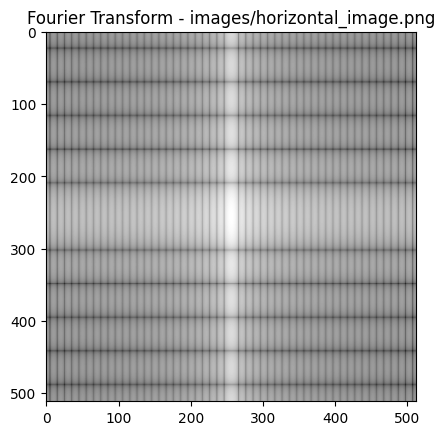

In [7]:
calculate_fourier_transform(image_horizontal_path)

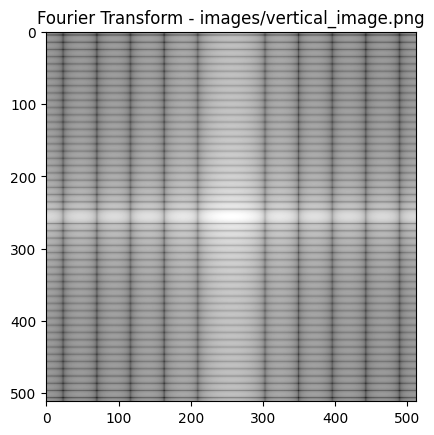

In [8]:
calculate_fourier_transform(image_vertical_path)

2. Dla dwóch wybranych obrazów zastosuj filtry dolno- i górnoprzepustowe w dziedzinie częstotliwości:
a) idealny
b) Gaussa
c) Butterwortha (n=2 i 3)
Dla wszystkich filtrów wybierz ten sam promień.

In [9]:
image_arduino_circuit_path = "images/arduino-circuit.jpg"
image_ship_path = "images/ship.jpg"

In [10]:
def ideal_filter(image_path, radius, flag):
    image = np.array(Image.open(image_path).convert('L'))
    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)

    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    if flag == 'low':
        mask = np.zeros((rows, cols), np.uint8)
        mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 1
    elif flag == 'high':
        mask = np.ones((rows, cols), np.uint8)
        mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 0
    else:
        raise ValueError("Flag should be either 'low' or 'high'.")

    f_shift_filtered = f_shift * mask
    f_ishift = np.fft.ifftshift(f_shift_filtered)
    image_back = np.fft.ifft2(f_ishift)
    image_back = np.abs(image_back)

    plt.subplot(1, 2, 1), plt.imshow(image, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    if flag == 'low':
        plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
        plt.title('Ideal Low Pass Filter'), plt.xticks([]), plt.yticks([])
    else:
        plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
        plt.title('Ideal High Pass Filter'), plt.xticks([]), plt.yticks([])
    plt.show()


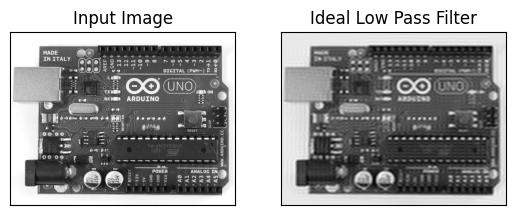

In [11]:
ideal_filter(image_arduino_circuit_path, radius=50, flag='low')

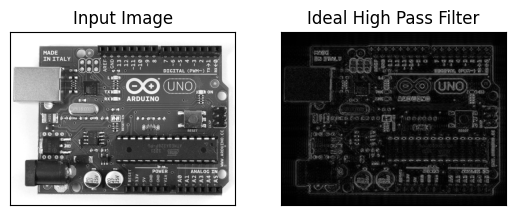

In [12]:
ideal_filter(image_arduino_circuit_path, radius=50, flag='high')

In [13]:
def filter_image(image_path, radius, flag, filter_type, n=None):
    image = cv2.imread(image_path, 0)

    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)

    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    if filter_type == 'ideal':
        if flag == 'low':
            mask = np.zeros((rows, cols), np.uint8)
            mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 1
        elif flag == 'high':
            mask = np.ones((rows, cols), np.uint8)
            mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 0
        else:
            raise ValueError("Flag should be either 'low' or 'high.'")
    elif filter_type == 'gaussian':
        x = np.linspace(-ccol, ccol, cols)
        y = np.linspace(-crow, crow, rows)
        x, y = np.meshgrid(x, y)
        g_mask = np.exp(-(x ** 2 + y ** 2) / (2 * radius ** 2))

        if flag == 'low':
            mask = g_mask
        elif flag == 'high':
            mask = 1 - g_mask
        else:
            raise ValueError("Flag should be either 'low' or 'high.'")
    elif filter_type == 'butterworth':
        x = np.linspace(-ccol, ccol, cols)
        y = np.linspace(-crow, crow, rows)
        x, y = np.meshgrid(x, y)
        d = np.sqrt(x ** 2 + y ** 2)

        if flag == 'low':
            mask = 1 / (1 + (d / radius) ** (2 * n))
        elif flag == 'high':
            mask = 1 - 1 / (1 + (d / radius) ** (2 * n))
        else:
            raise ValueError("Flag should be either 'low' or 'high.'")
    else:
        raise ValueError("Filter type should be 'ideal', 'gaussian', or 'butterworth'.")

    f_shift_filtered = f_shift * mask
    f_ishift = np.fft.ifftshift(f_shift_filtered)
    image_back = np.fft.ifft2(f_ishift)
    image_back = np.abs(image_back)

    plt.subplot(1, 2, 1), plt.imshow(image, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    if flag == 'low':
        if filter_type == 'ideal':
            plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
            plt.title('Ideal Low Pass Filter'), plt.xticks([]), plt.yticks([])
        elif filter_type == 'gaussian':
            plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
            plt.title('Gaussian Low Pass Filter'), plt.xticks([]), plt.yticks([])
        elif filter_type == 'butterworth':
            plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
            plt.title(f"Butterworth Low Pass Filter (n={n})"), plt.xticks([]), plt.yticks([])
    else:
        if filter_type == 'ideal':
            plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
            plt.title('Ideal High Pass Filter'), plt.xticks([]), plt.yticks([])
        elif filter_type == 'gaussian':
            plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
            plt.title('Gaussian High Pass Filter'), plt.xticks([]), plt.yticks([])
        elif filter_type == 'butterworth':
            plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
            plt.title(f"Butterworth High Pass Filter (n={n})"), plt.xticks([]), plt.yticks([])
    plt.show()


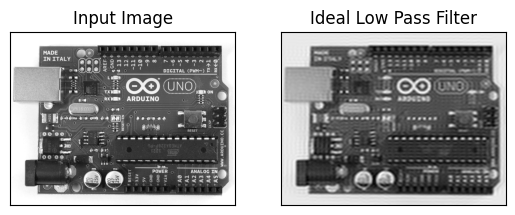

In [14]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="ideal", flag="low", n=None)

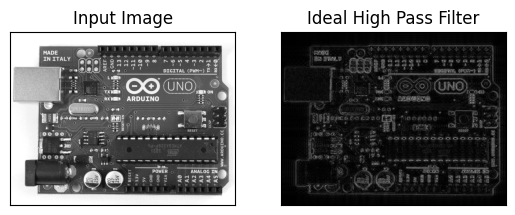

In [15]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="ideal", flag="high", n=None)

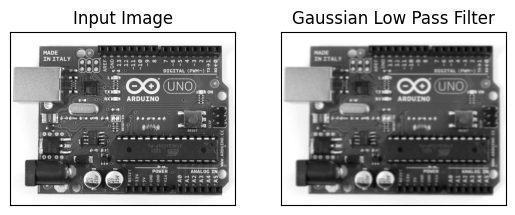

In [16]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="gaussian", flag="low", n=None)

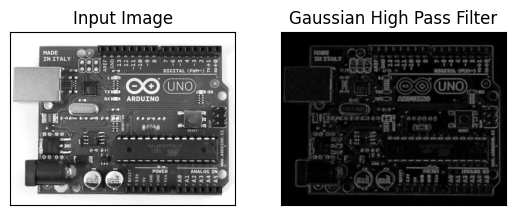

In [17]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="gaussian", flag="high", n=None)

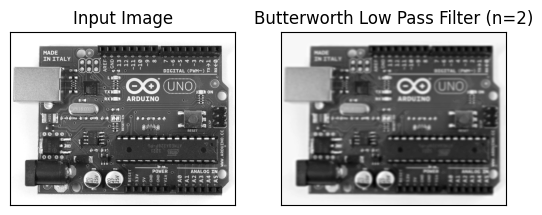

In [18]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="butterworth", flag="low", n=2)

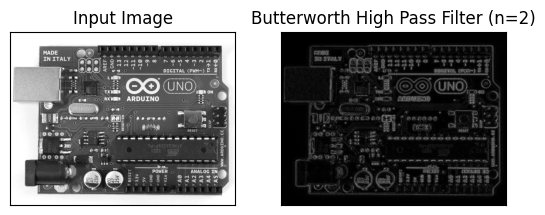

In [19]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="butterworth", flag="high", n=2)

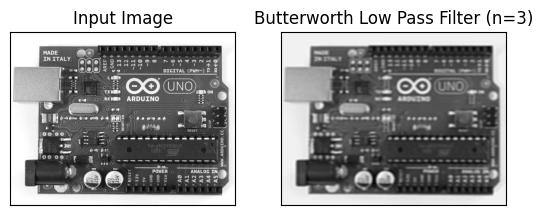

In [20]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="butterworth", flag="low", n=3)

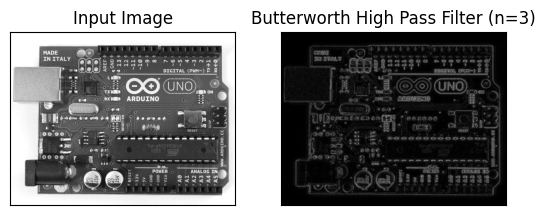

In [21]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="butterworth", flag="high", n=3)

In [23]:
image_arduino_circuit_path = "images/ship.png"

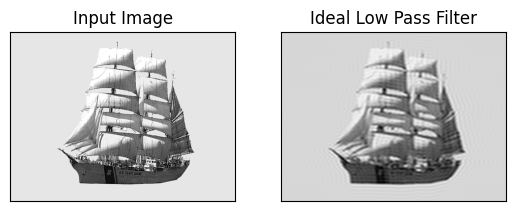

In [24]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="ideal", flag="low", n=None)

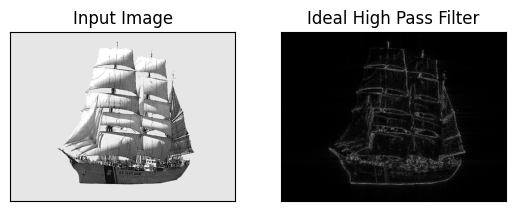

In [26]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="ideal", flag="high", n=None)

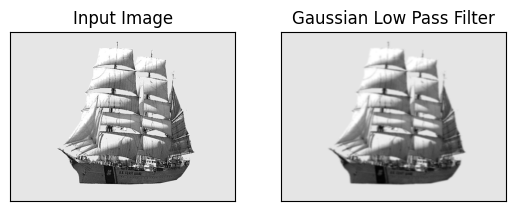

In [27]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="gaussian", flag="low", n=None)

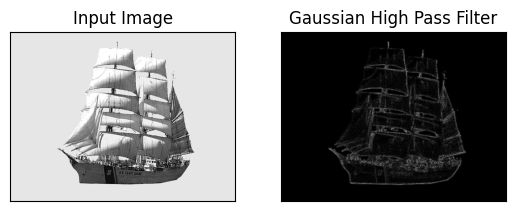

In [28]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="gaussian", flag="high", n=None)

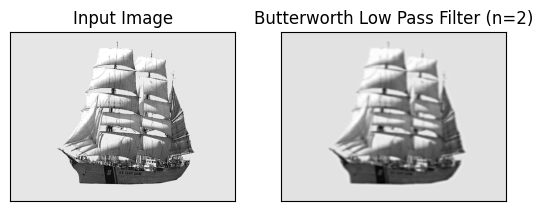

In [29]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="butterworth", flag="low", n=2)

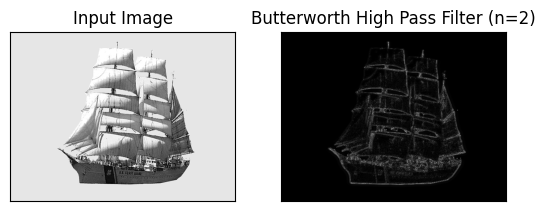

In [30]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="butterworth", flag="high", n=2)

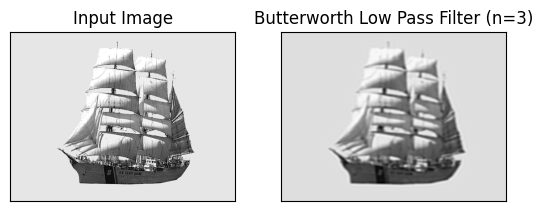

In [32]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="butterworth", flag="low", n=3)

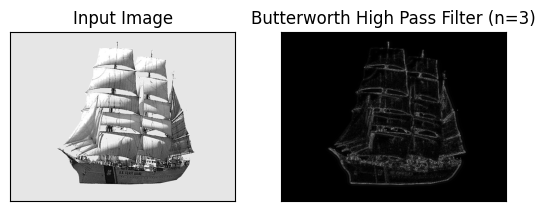

In [33]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="butterworth", flag="high", n=3)